# GO terms DEGs
In our transcriptomics visualization notebook, we exported some groups of genes that we want to get GO term enrichments for; here is where we'll do that, using the PANTHER API.

In [105]:
from os import listdir
from os.path import splitext, isfile
import requests
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np
from upsetplot import from_contents, plot, UpSet
import warnings
import matplotlib.pyplot as plt
import math

## Read in the data

In [4]:
data_dir = '../data/gene_lists/'
data = {}
for f in listdir(data_dir):
    if isfile(f'{data_dir}/{f}'):
        with open(f'{data_dir}/{f}') as myf:
            data[splitext(f)[0]] = [l.strip() for l in myf.readlines()]

Define the semantic mapping for later use:

In [23]:
conditions_semantic = {
    '1h_vs_7h_2o2_gene_list': '7 hours vs. 1 hour at 2% oxygen',
    '1h_vs_7h_40o2_gene_list': '7 hours vs. 1 hour at 40% oxygen',
    '1h_vs_7h_21o2_gene_list': '7 hours vs. 1 hour at 21% oxygen',
    '1h_vs_7h_2o2_filtered_gene_list': '7 hours vs. 1 hour at 2% oxygen, filtered',
    '1h_vs_7h_40o2_filtered_gene_list': '7 hours vs. 1 hour at 40% oxygen, filtered',
    '1h_o2_40_21_gene_list': '40% vs. 21% oxygen at 1 hour',
    '7h_o2_2_21_gene_list': '2% vs. 21% oxygen at 7 hours',
    '1h_o2_2_21_gene_list': '2% vs. 21% oxygen at 1 hour',
    '7h_o2_40_21_gene_list': '40% vs. 21% oxygen at 7 hours'
}
reverse_semantic = {v: k for k, v in conditions_semantic.items()}

Drop the reference list (only needed if doing local enrichment with GOAtools):

In [6]:
del data['reference_gene_list']

## Define API call function
We're going to use the [PANTHER API](https://pantherdb.org/services/openAPISpec.jsp) to do our GO term enrichment.

In [3]:
def getPANTHER(query, checkPageInfo=True):
    """
    Get GO terms from a mmultiple-page search result.
    """
    # Check number of pages
    r = requests.get(query, headers={ "Accept" : "application/json"})
    if not r.ok:
      r.raise_for_status()
      sys.exit()
    responseBody = r.json()
    overall_jsons = responseBody['results']

    return overall_jsons

## Formulate queries and make API call

In [26]:
enrichments = defaultdict(dict)
for comp, genes in tqdm(data.items()):
    gene_list = ','.join(genes)
    enriches = {}
    for go_name, go_set in {
                            'GO%3A0008150': 'biological_process',
                            'GO%3A0003674': 'molecular_function',
                            'GO%3A0005575': 'cellular_component'
                            }.items():
        enrich_query = f'https://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList={gene_list}&organism=3702&annotDataSet={go_name}&enrichmentTestType=FISHER&correction=FDR'
        result_json = getPANTHER(enrich_query)
        enriches[go_set] = result_json
    enrichments[comp] = enriches

100%|██████████| 9/9 [01:30<00:00, 10.06s/it]


## Process results
Note that the chimeric transcripts and novel genes are not able to be mapped to GO terms, and so are excluded. In the `unmapped_id` lists there are also some normal-looking TAIR ID's; I assume that there is some base error in mapping genes to GO terms wtih this tool.

In [5]:
def processGOenrichments(enrichments, data, conditions_semantic):
    """
    Make a summary dataframe with GO terms from each aspect that are enriched
    in each group, and print a summary of the numbers.
    """
    processed_go = {
        'group': [],
        'aspect': [],
        'term': [],
        'GOid': [],
        'p_value_fdr': []
    }
    for group, res in enrichments.items():
        for aspect in res:
            for termDict in res[aspect]['result']:
                if termDict['fdr'] < 0.05:
                    processed_go['group'].append(group)
                    processed_go['aspect'].append(aspect)
                    processed_go['term'].append(termDict['term']['label'])
                    try:
                        processed_go['GOid'].append(termDict['term']['id'])
                    except KeyError:
                        processed_go['GOid'].append(np.nan)
                    processed_go['p_value_fdr'].append(termDict['fdr'])

    go_results = pd.DataFrame(processed_go)
    go_results = go_results.set_index(['group', 'aspect']).sort_index()

    for group in data:
        print(f'\nFor comparison group {conditions_semantic[group]}, there are...')
        for aspect in ['biological_process', 'molecular_function', 'cellular_component']:
            try:
                print(f'{len(go_results.loc[(group, aspect)])} {aspect} GO terms')
            except KeyError:
                print(f'0 {aspect} GO terms')
        print(f'... enriched, for a total of {len(data[group])} genes in the comparison.\n')

    return go_results

In [116]:
go_enrichment_data = processGOenrichments(enrichments, data, conditions_semantic)
go_enrichment_data.head()


For comparison group 7 hours vs. 1 hour at 21% oxygen, there are...
138 biological_process GO terms
28 molecular_function GO terms
60 cellular_component GO terms
... enriched, for a total of 1166 genes in the comparison.


For comparison group 7 hours vs. 1 hour at 40% oxygen, there are...
149 biological_process GO terms
19 molecular_function GO terms
82 cellular_component GO terms
... enriched, for a total of 2094 genes in the comparison.


For comparison group 40% vs. 21% oxygen at 1 hour, there are...
6 biological_process GO terms
1 molecular_function GO terms
0 cellular_component GO terms
... enriched, for a total of 68 genes in the comparison.


For comparison group 7 hours vs. 1 hour at 2% oxygen, filtered, there are...
181 biological_process GO terms
31 molecular_function GO terms
51 cellular_component GO terms
... enriched, for a total of 1492 genes in the comparison.


For comparison group 2% vs. 21% oxygen at 1 hour, there are...
16 biological_process GO terms
5 molecular_fu

term  \
group                aspect                                                             
1h_o2_2_21_gene_list biological_process                  xyloglucan metabolic process   
                     biological_process                  cellular response to hypoxia   
                     biological_process  cellular response to decreased oxygen levels   
                     biological_process            cellular response to oxygen levels   
                     biological_process                          response to chemical   

                                               GOid  p_value_fdr  
group                aspect                                       
1h_o2_2_21_gene_list biological_process  GO:0010411     0.000136  
                     biological_process  GO:0071456     0.000108  
                     biological_process  GO:0036294     0.000076  
                     biological_process  GO:0071453     0.000059  
                     biological_process  GO:0042221     0.000060

Save the dataframe output, but replace outer index with semantic values first:

In [109]:
multi = go_enrichment_data.index.tolist()
multi_replace = pd.MultiIndex.from_tuples([(conditions_semantic[i], j) for i, j in multi])
go_enrichment_data.index = multi_replace
go_enrichment_data.head()

term  \
2% vs. 21% oxygen at 1 hour biological_process                  xyloglucan metabolic process   
                            biological_process                  cellular response to hypoxia   
                            biological_process  cellular response to decreased oxygen levels   
                            biological_process            cellular response to oxygen levels   
                            biological_process                          response to chemical   

                                                      GOid  p_value_fdr  
2% vs. 21% oxygen at 1 hour biological_process  GO:0010411     0.000136  
                            biological_process  GO:0071456     0.000108  
                            biological_process  GO:0036294     0.000076  
                            biological_process  GO:0071453     0.000059  
                            biological_process  GO:0042221     0.000060

In [110]:
go_enrichment_data.to_csv('../data/panther_API_go_enrichments/PANTHER_GO_enrichments_all_categories_18Mar2025.csv', index=True)

In [17]:
## START HERE if you don't want to re-run enrichment
go_enrichment_data = pd.read_csv('../data/panther_API_go_enrichments/PANTHER_GO_enrichments_all_categories_18Mar2025.csv').rename(columns={'Unnamed: 0': 0, 'Unnamed: 1': 1}).set_index([0, 1])
go_enrichment_data.head()

term  \
0                           1                                                                  
2% vs. 21% oxygen at 1 hour biological_process                  xyloglucan metabolic process   
                            biological_process                  cellular response to hypoxia   
                            biological_process  cellular response to decreased oxygen levels   
                            biological_process            cellular response to oxygen levels   
                            biological_process                          response to chemical   

                                                      GOid  p_value_fdr  
0                           1                                            
2% vs. 21% oxygen at 1 hour biological_process  GO:0010411     0.000136  
                            biological_process  GO:0071456     0.000108  
                            biological_process  GO:0036294     0.000076  
                            biological_process  GO:0071453     0.000059  
                            biological_process  GO:0042221     0.000060

I'd like to know what terms, if any, overlap between the groups. Let's make some UpSet plots. I mostly care about the same kinds of comparisons that I did for the differential expression, so let's make one plot for each aspect for each of the time and oxygen comparisons.

In [28]:
# Convert back to underscore condition names
multi = go_enrichment_data.index.tolist()
multi_replace = pd.MultiIndex.from_tuples([(reverse_semantic[i], j) for i, j in multi])
go_enrichment_data.index = multi_replace
go_enrichment_data.head()

term  \
1h_o2_2_21_gene_list biological_process                  xyloglucan metabolic process   
                     biological_process                  cellular response to hypoxia   
                     biological_process  cellular response to decreased oxygen levels   
                     biological_process            cellular response to oxygen levels   
                     biological_process                          response to chemical   

                                               GOid  p_value_fdr  
1h_o2_2_21_gene_list biological_process  GO:0010411     0.000136  
                     biological_process  GO:0071456     0.000108  
                     biological_process  GO:0036294     0.000076  
                     biological_process  GO:0071453     0.000059  
                     biological_process  GO:0042221     0.000060

In [29]:
go_enrich_time = go_enrichment_data[go_enrichment_data.index.get_level_values(0).isin([#'1h_vs_7h_2o2_gene_list',
    # '1h_vs_7h_40o2_gene_list',
    # '1h_vs_7h_21o2_gene_list',
    '1h_vs_7h_2o2_filtered_gene_list',
    '1h_vs_7h_40o2_filtered_gene_list'])]

go_enrich_o2 = go_enrichment_data[go_enrichment_data.index.get_level_values(0).isin(['1h_o2_40_21_gene_list',
    '7h_o2_2_21_gene_list',
    '1h_o2_2_21_gene_list',
    '7h_o2_40_21_gene_list'])]

In [30]:
def plot_go_enrichment_overlaps(enriches, conditions_semantic):
    """
    Plot enrichment overlaps for each of the three aspects for a set of groups.
    """
    warnings.filterwarnings('ignore') 
    for aspect in set(enriches.index.get_level_values(1)):
        go_terms = {}
        for group in set(enriches.index.get_level_values(0)):
            try:
                go_terms[conditions_semantic[group]] = list(set(enriches.loc[(group, aspect), 'GOid'].tolist()))
            except KeyError:
                go_terms[conditions_semantic[group]] = []
        to_plot = from_contents(go_terms)
        plot(to_plot, show_counts=True, sort_categories_by='input')
        plt.title(aspect)

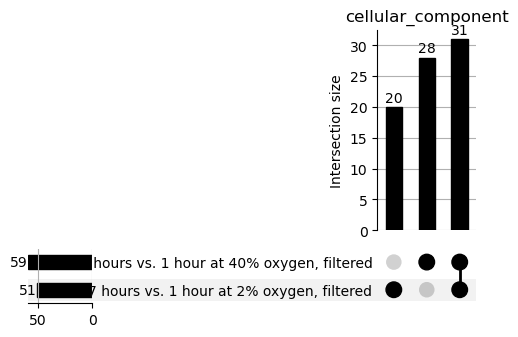

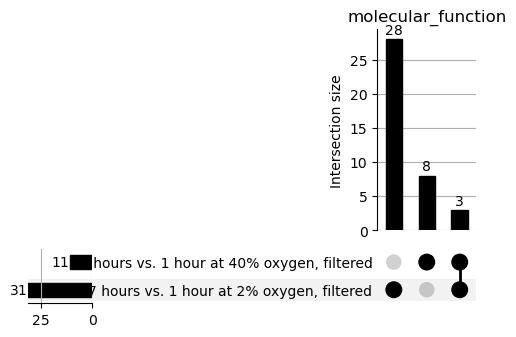

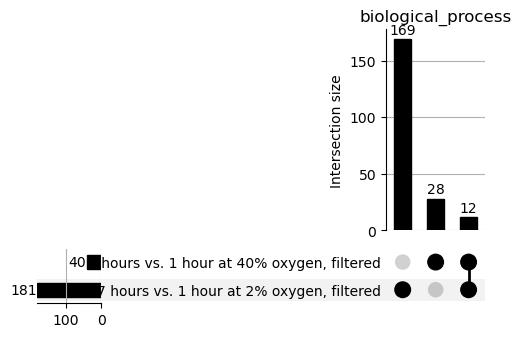

In [31]:
plot_go_enrichment_overlaps(go_enrich_time, conditions_semantic)

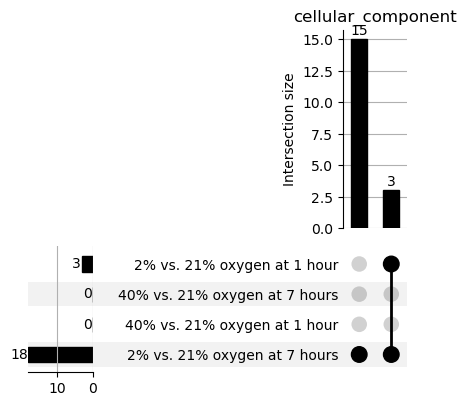

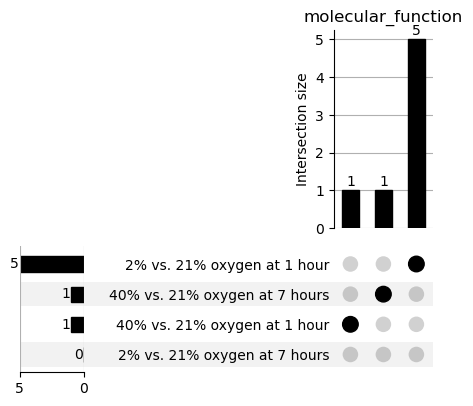

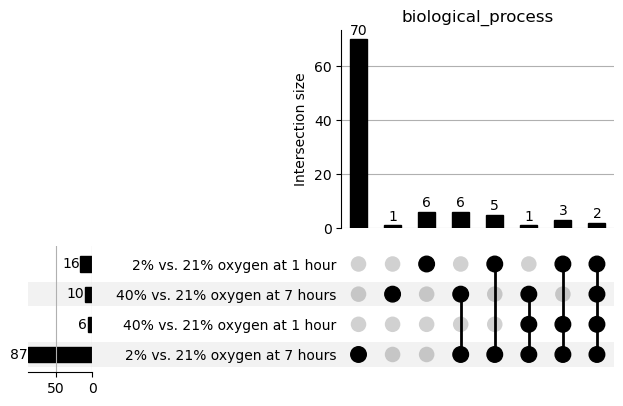

In [32]:
plot_go_enrichment_overlaps(go_enrich_o2, conditions_semantic)

## Additional GO analyses
### Oxygen concentration overlaps

In [54]:
all_o2_comps = {}
with open('../data/gene_lists/2o2_all_comps_overlaps_gene_list.txt') as f:
    all_o2_comps['2o2'] = [l.strip() for l in f.readlines()]
with open('../data/gene_lists/40o2_all_comps_overlaps_gene_list.txt') as f:
    all_o2_comps['40o2'] = [l.strip() for l in f.readlines()]

In [4]:
o2_enrichments = defaultdict(dict)
for comp, genes in tqdm(all_o2_comps.items()):
    gene_list = ','.join(genes)
    enriches = {}
    for go_name, go_set in {
                            'GO%3A0008150': 'biological_process',
                            'GO%3A0003674': 'molecular_function',
                            'GO%3A0005575': 'cellular_component'
                            }.items():
        enrich_query = f'https://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList={gene_list}&organism=3702&annotDataSet={go_name}&enrichmentTestType=FISHER&correction=FDR'
        result_json = getPANTHER(enrich_query)
        enriches[go_set] = result_json
    o2_enrichments[comp] = enriches

100%|██████████| 2/2 [00:15<00:00,  7.88s/it]


In [6]:
o2_conditions_semantic = {
    '2o2': '2% oxygen, all comparisons',
    '40o2': '40% oxygen, all comparisons'
}

In [7]:
o2_go_enrichment_data = processGOenrichments(o2_enrichments, all_o2_comps, o2_conditions_semantic)
o2_go_enrichment_data.head()


For comparison group 2% oxygen, all comparisons, there are...
50 biological_process GO terms
0 molecular_function GO terms
0 cellular_component GO terms
... enriched, for a total of 207 genes in the comparison.


For comparison group 40% oxygen, all comparisons, there are...
0 biological_process GO terms
0 molecular_function GO terms
0 cellular_component GO terms
... enriched, for a total of 8 genes in the comparison.



term  \
group aspect                                                                  
2o2   biological_process                               response to chemical   
      biological_process                               response to stimulus   
      biological_process                        cellular response to stress   
      biological_process  multicellular organismal-level iron ion homeos...   
      biological_process  multicellular organismal-level chemical homeos...   

                                GOid   p_value_fdr  
group aspect                                        
2o2   biological_process  GO:0042221  5.372990e-13  
      biological_process  GO:0050896  7.561177e-13  
      biological_process  GO:0033554  1.322829e-08  
      biological_process  GO:0060586  1.648962e-08  
      biological_process  GO:0140962  3.178490e-08

In [8]:
o2_go_enrichment_data.to_csv('../data/panther_API_go_enrichments/PANTHER_GO_enrichments_all_o2_comparisons_19March2025.csv', index=True)

In [87]:
## START HERE if you don't want to redo the enrichment
o2_go_enrichment_data = pd.read_csv('../data/panther_API_go_enrichments/PANTHER_GO_enrichments_all_o2_comparisons_19March2025.csv').set_index(['group', 'aspect'])
o2_go_enrichment_data.head()

term  \
group aspect                                                                  
2o2   biological_process                               response to chemical   
      biological_process                               response to stimulus   
      biological_process                        cellular response to stress   
      biological_process  multicellular organismal-level iron ion homeos...   
      biological_process  multicellular organismal-level chemical homeos...   

                                GOid   p_value_fdr  
group aspect                                        
2o2   biological_process  GO:0042221  5.372990e-13  
      biological_process  GO:0050896  7.561177e-13  
      biological_process  GO:0033554  1.322829e-08  
      biological_process  GO:0060586  1.648962e-08  
      biological_process  GO:0140962  3.178490e-08

## Where did they come from, Cotton Eyed GO?
We want to know, for each of the genes, if the enriched GO terms are experimentally validated or just computationally predicted. The PANTHER API unfortunately doesn't return which genes have what GO terms in the enrichment, so we'll have to implement a workaround. First, let's try doing this with the GO slim provided by TAIR.

In [154]:
tair_goslim = pd.read_csv('../data/tair_go/ATH_GO_GOSLIM.txt', sep='\t', header=5, encoding='Windows-1252', names=[
     'locus_name',
    'TAIR_accession',
    'object_name',
    'relationship_type',
    'GO_term',
    'GO_ID',
    'TAIR Keyword ID',
    'Aspect',
    'GOslim_term',
    'Evidence_code',
    'Evidence_description',
    'Evidence_with',
    'Reference',
    'Annotator',
    'Date_annotated'
])
tair_goslim.head(2)

,locus_name,TAIR_accession,object_name,relationship_type,GO_term,GO_ID,TAIR Keyword ID,Aspect,GOslim_term,Evidence_code,Evidence_description,Evidence_with,Reference,Annotator,Date_annotated
0,AT1G01010,locus:2200935,AT1G01010,enables,transcription cis-regulatory region binding,GO:0000976,35767,F,DNA binding,IPI,yeast one-hybrid assay,AGI_LocusCode:AT2G38290,Publication:501786139|PMID:30356219,sibrady,2020-12-18
1,AT1G01010,gene:2200934,AT1G01010.1,located in,nucleus,GO:0005634,537,C,nucleus,ISM,predicted protein features,NaN,AnalysisReference:501780126,rkaundal,2018-08-31


First, let's see if there is an overlap between the GO terms in our enrichment and the terms in the GOslim.

In [67]:
tair_gos = set(tair_goslim.GO_ID.tolist())
enrichment_GOs = set(o2_go_enrichment_data.GOid.tolist())
print(f'There are {len(tair_gos)} unique GO terms in the TAIR slim.')
print(f'There are {len(enrichment_GOs)} unique GO terms in the GO enrichment for 2% all overlap.')
print(f'The intersection between these groups is {len(enrichment_GOs.intersection(tair_gos))}')

There are 7079 unique GO terms in the TAIR slim.
There are 50 unique GO terms in the GO enrichment for 2% all overlap.
The intersection between these groups is 34


Very unfortunately, the TAIR GO terms don't include all of the terms in our enrichment. It continues to be unclear to me why this is, but it may have to do with TAIR filtering the GO terms based on some parameters for inclusion in their database. However, maybe that is a good thing -- I would assume this filtering is a QC metric, so maybe our analysis is better off if we exclude terms we can't map to genes here. For now, we'll move forward with that assumption, and we can circle back later to make sure that QC is the reason the overlap here is incomplete.

### Associating genes with GO terms

In [68]:
term2genes = defaultdict(list)
for term in o2_go_enrichment_data.GOid.tolist():
    genes = goslim[goslim['GO_ID'] == term].loc[:, 'locus_name'].tolist()
    if len(genes) == 0:
        continue
    # Remove any that aren't in the comparison
    genes = [g for g in genes if g in all_o2_comps['2o2']]
    term2genes[term] = genes

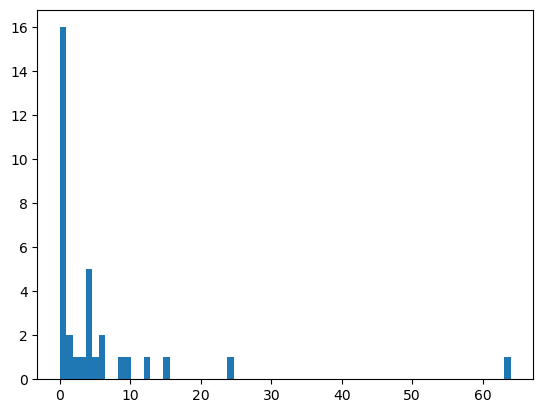

In [72]:
_ = plt.hist([len(gs) for gs in term2genes.values()], bins=70)

Unfortunately, even GO terms that appear in the TAIR GO from our enrichment mostly appear to have no genes associated with them. I don't know how to explain this; maybe that the QC also removes Go terms without certain evidence codes?

### Looking at the GO slims for the enriched set
We can better summarize a group of GO terms by using their GO slim mappings, which are parent categories that lump the more specific terms into groups.

In [80]:
id2slim_df = tair_goslim[['GO_ID', 'GOslim_term']]
id2slim_df.head()

,GO_ID,GOslim_term
0,GO:0000976,DNA binding
1,GO:0005634,nucleus
2,GO:0006355,other cellular processes
3,GO:0006355,other metabolic processes
4,GO:0000976,nucleic acid binding


In [90]:
id2slim = {k: list(set(v)) for k, v in id2slim_df.groupby('GO_ID').agg(list).to_dict()['GOslim_term'].items()}
for ids, slims in id2slim.items():
    if len(slims) > 1:
        drop_other = [sl for sl in slims if 'other' not in sl]
        id2slim[ids] = drop_other

Unfortunately, the GO slim mappings are not consistent across GO terms in this slim file. In the above cell, I dropped generic terms containing the word other (i.e. "other catalytic activity") if the term had other slim mappings. However, there are still multiple instances where a term has increasingly generic slim mappings, and there's not a reliable way to get rid of them in order of specificity without importing the entire GO tree and walking it to find the most specific ones. Since we're just looking for a general vibe here, I'm going to do a naive solution where I order all the slim mappings alphabetically and just choose the first one, to be consistent across terms.

In [98]:
id2slim_unique = {
    k: sorted(v)[0] if len(v) > 0 else ''
    for k, v in id2slim.items()
}

In [101]:
o2_go_enrichment_data['GOslim'] = o2_go_enrichment_data['GOid'].map(id2slim_unique)

Let's make a visualization:

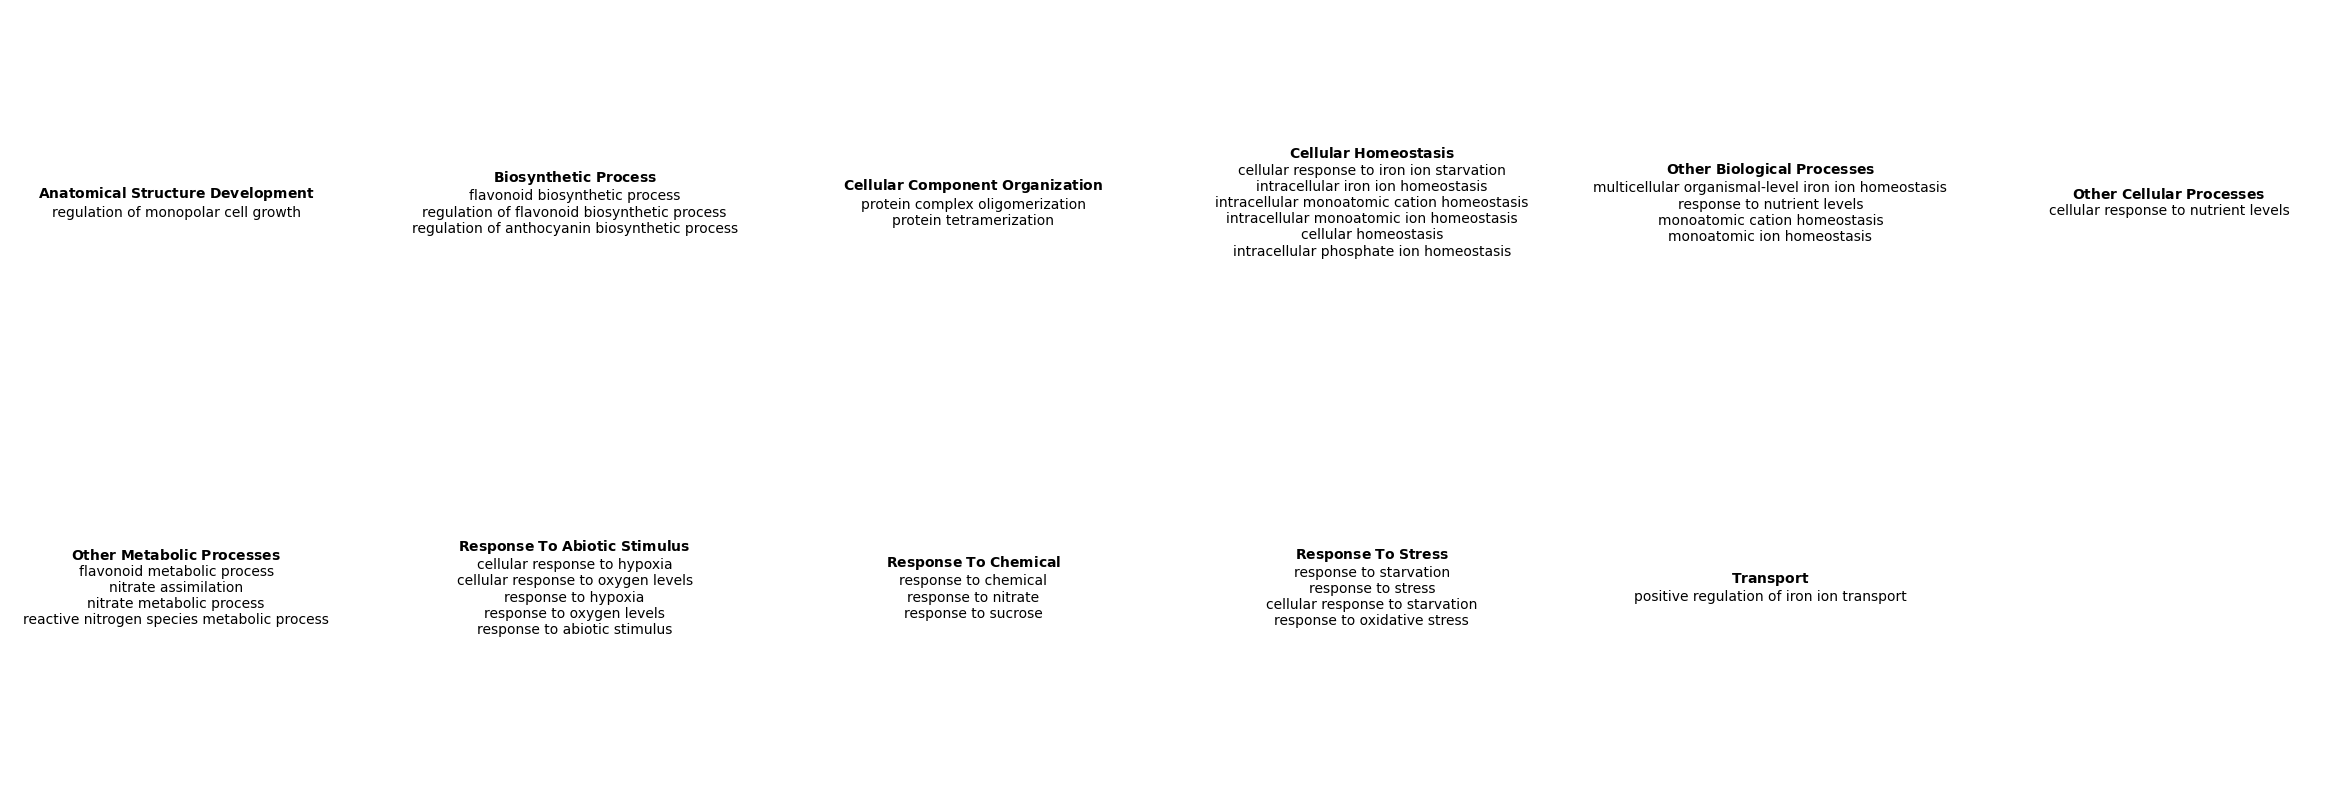

In [147]:
goslim_to_plot = o2_go_enrichment_data.dropna(subset='GOslim').groupby('GOslim').agg(list)['term'].to_dict()

fig, axs = plt.subplots(2, 6, figsize=(30, 10))

for ax, goslim in zip(axs.flat, goslim_to_plot):

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    bolded_title = ' '.join([r'$\bf{' + i + '}$' for i in goslim.title().split(' ')])
    s = bolded_title + '\n' + '\n'.join(goslim_to_plot[goslim])
    ax.text(0.5, 0.5,
           s,
           ha='center',
           va='center')
    ax.set_axis_off()
axs.flat[-1].set_axis_off()
plt.subplots_adjust(hspace=0)

### Making the gene number plot
We're going to exclude terms that have a count of 0, as these should have genes but don't because of whatever QC the TAIR file has done on it.

In [157]:
id2term = tair_goslim[['GO_ID', 'GO_term']].drop_duplicates().set_index('GO_ID').to_dict()['GO_term']

In [165]:
term2genes_nozero = {k: v for k, v in term2genes.items() if len(v) > 0}
pairs_to_plot = {k: len(v) for k, v in term2genes_nozero.items()}
pairs_to_plot = {k: v for k, v in sorted(pairs_to_plot.items(), key=lambda item: item[1])}

(np.float64(0.0), np.float64(1.05), np.float64(-1.295), np.float64(18.395))

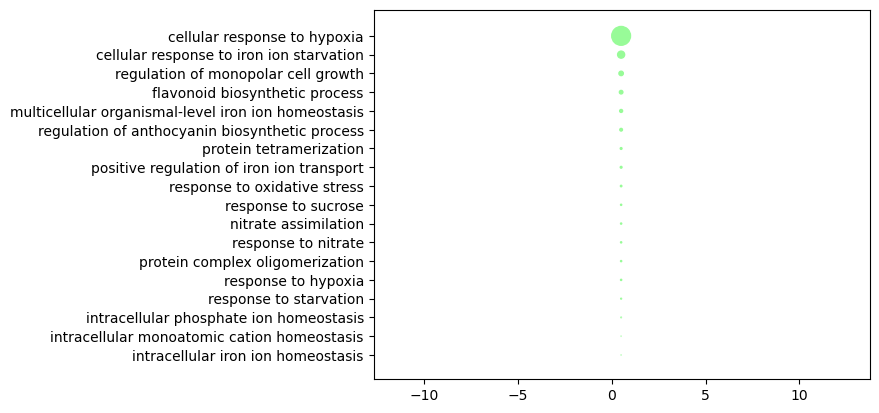

In [204]:
fig, ax = plt.subplots()

# Plot a horizontal bar plot to get the ytick labels
ax.barh([id2term[k] for k in pairs_to_plot.keys()], [0]*(len(pairs_to_plot)))

for i, term in enumerate(pairs_to_plot):

    radius = pairs_to_plot[term]/(2*max(pairs_to_plot.values()))
    circ = plt.Circle((0.5, i), radius=radius, color='palegreen')
    ax.add_patch(circ)
ax.axis("equal")

### Looking at evidence codes
Another thing we want to know is what kinds of evidence codes the GO terms, specifically the response to oxygen terms.

In [211]:
o2_gos = tair_goslim[(tair_goslim['locus_name'].isin(all_o2_comps['2o2'])) & (tair_goslim['GO_term'].isin(goslim_to_plot['response to abiotic stimulus']))]
o2_gos.head()

,locus_name,TAIR_accession,object_name,relationship_type,GO_term,GO_ID,TAIR Keyword ID,Aspect,GOslim_term,Evidence_code,Evidence_description,Evidence_with,Reference,Annotator,Date_annotated
42186,AT1G43800,locus:2029142,AT1G43800,acts upstream of or within,cellular response to hypoxia,GO:0071456,33992,P,response to abiotic stimulus,HEP,none,NONE,Publication:501786480|PMID:31519798,baileyserr,2019-09-19
42189,AT1G43800,locus:2029142,AT1G43800,acts upstream of or within,cellular response to hypoxia,GO:0071456,33992,P,response to chemical,HEP,none,NONE,Publication:501786480|PMID:31519798,baileyserr,2019-09-19
42190,AT1G43800,locus:2029142,AT1G43800,acts upstream of or within,cellular response to hypoxia,GO:0071456,33992,P,response to stress,HEP,none,NONE,Publication:501786480|PMID:31519798,baileyserr,2019-09-19
42191,AT1G43800,locus:2029142,AT1G43800,acts upstream of or within,cellular response to hypoxia,GO:0071456,33992,P,other cellular processes,HEP,none,NONE,Publication:501786480|PMID:31519798,baileyserr,2019-09-19
63879,AT1G66880,locus:2204465,AT1G66880,acts upstream of or within,cellular response to hypoxia,GO:0071456,33992,P,response to stress,HEP,none,NONE,Publication:501786480|PMID:31519798,baileyserr,2019-09-19


In [213]:
o2_gos.groupby('Evidence_code').count()

,locus_name,TAIR_accession,object_name,relationship_type,GO_term,GO_ID,TAIR Keyword ID,Aspect,GOslim_term,Evidence_description,Evidence_with,Reference,Annotator,Date_annotated
Evidence_code,,,,,,,,,,,,,,
HEP,64,64,64,64,64,64,64,64,64,64,64,64,64,64
IMP,2,2,2,2,2,2,2,2,2,2,2,2,2,2
TAS,2,2,2,2,2,2,2,2,2,2,2,2,2,2


Looking at the [GO evidence codes](https://geneontology.org/docs/guide-go-evidence-codes/), HEP is "Inferred from High Throughput Expression Pattern", IMP is "Inferred from Mutant Phenotype", and TAS is "Traceable Author Statement". IMP and HEP are considered to be experimental evidence codes (EXP), while TAS is part of the author statement evidence codes category.